In [1]:
import pandas as pd
import os
import numpy as np

In [2]:
results_dir = '../results'
style_csv = 'style_feats_train.csv'
embs_csv = 'alberto_sent_embs_pooled_train.csv'
off_csv = 'offensiveness_train.csv'
uni_bi_csv = 'merged_ddf.xls'

In [3]:
style_df = pd.read_csv(os.path.join(results_dir, style_csv), index_col=0)
embs_df = pd.read_csv(os.path.join(results_dir, embs_csv), index_col=0)
off_df = pd.read_csv(os.path.join(results_dir, off_csv), index_col=0)
uni_bi_df = pd.read_csv(os.path.join(results_dir, uni_bi_csv), index_col=0)

In [4]:
style_df.head()

,hs,stereotype,raw_text,num_tokens,num_sentences,avg_sent_length,avg_word_length,uppercase_words_dist,num_mentions,num_hashtags,...,deprel_dist_parataxis:obj,deprel_dist_parataxis:discourse,deprel_dist_goeswith,deprel_dist_csubj:pass,deprel_dist_nsubj:outer,deprel_dist_reparandum,obj_pre,obj_post,subj_pre,subj_post
id,,,,,,,,,,,,,,,,,,,,,
2066,0,0,"È terrorismo anche questo, per mettere in uno ...",20,1,20.0,5.166667,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
2045,0,0,@user @user infatti finché ci hanno guadagnato...,15,1,15.0,4.733333,0.0,2,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
61,0,0,"Corriere: Tangenti, Mafia Capitale dimenticata...",13,1,13.0,6.181818,0.0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1259,0,0,"@user ad uno ad uno, perché quando i migranti ...",21,1,21.0,4.789474,0.0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
949,0,0,Il divertimento del giorno? Trovare i patrioti...,24,2,12.0,5.650000,0.0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0


In [5]:
uni_bi_df.columns[:10]

Index(['text_processed', 'tokenized', 'n_token', 'badword', 'uppercase_count',
       'hs', 'anche', 'essere', 'mentre', 'mettere'],
      dtype='object')

In [4]:
train_y = style_df['hs']
uni_bi_df = uni_bi_df.drop(['text_processed', 'tokenized', 'uppercase_count', 'n_token', 'hs'], axis=1)
style_df = style_df.drop(['hs', 'stereotype', 'raw_text'], axis=1)

## Models

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, StratifiedKFold, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, chi2

In [5]:
style_df = style_df.reset_index(drop=True)
embs_df = embs_df.reset_index(drop=True)
off_df = off_df.reset_index(drop=True)
uni_bi_df = uni_bi_df.reset_index(drop=True)
style_df.shape, embs_df.shape, off_df.shape, uni_bi_df.shape

((6837, 91), (6837, 768), (6837, 1), (6837, 6350))

In [6]:
train_X = pd.concat([style_df, embs_df, off_df, uni_bi_df], axis=1)
train_X.shape

(6837, 7210)

In [26]:
param_grid = {
    'eta': np.linspace(0.01, 0.3, 10), 
    'max_depth': np.arange(3, 20),
    'min_child_weight': np.arange(1, 10), 
    'subsample': np.linspace(0.5, 1.0, 5),
    'colsample_bytree': np.linspace(0.5, 1.0, 5),
    'gamma': np.linspace(0, 5, 10),
    'lambda': np.logspace(-2, 2, 10),
    'alpha': np.logspace(-2, 2, 10), 
    'scale_pos_weight': [0,5, 1, 2, 5], 
    'n_estimators': np.arange(50, 500, 50)
}

xgb = XGBClassifier(
    tree_method='hist', 
    objective='binary:logistic', 
    eval_metric='logloss'
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=100,
    scoring='f1_macro',
    cv=cv,
    verbose=3,
    random_state=42,
    n_jobs=-1 
)

scaler = MinMaxScaler()
train_X_scaled = scaler.fit_transform(train_X)

random_search.fit(train_X_scaled, train_y)

print("Best Parameters:", random_search.best_params_)
print("Best Macro F1 Score:", random_search.best_score_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'subsample': 0.75, 'scale_pos_weight': 5, 'n_estimators': 250, 'min_child_weight': 1, 'max_depth': 8, 'lambda': 0.5994842503189409, 'gamma': 0.5555555555555556, 'eta': 0.07444444444444444, 'colsample_bytree': 0.75, 'alpha': 0.0774263682681127}
Best Macro F1 Score: 0.7636710541986644


In [8]:
%%time
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),  
    ('clf',  XGBClassifier(subsample=0.75, scale_pos_weight=5, n_estimators=250, min_child_weight=1, max_depth=8, reg_lambda=0.5994,
            gamma=0.555, eta=0.0744, colsample_bytree=0.75, alpha=0.0774, eval_metric='logloss'))
], verbose=True)

splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'accuracy': 'accuracy',
    'precision_macro': make_scorer(precision_score, average='macro', zero_division=0),
    'recall_macro': make_scorer(recall_score, average='macro', zero_division=0),
    'f1_macro': make_scorer(f1_score, average='macro', zero_division=0),
    'f1_positive': make_scorer(f1_score, pos_label=1, zero_division=0)
}

scores = cross_validate(pipeline, train_X, train_y, scoring=scoring, cv=splitter)

print("Mean macro-f1:", np.mean(scores['test_f1_macro']).round(3))
print("Standard deviation macro-f1:", np.std(scores['test_f1_macro']).round(3))


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.6s
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.1min
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.1min
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.1min
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.2min
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.2min
Mean macro-f1: 0.771
Standard deviation macro-f1: 0.011
CPU times: total: 1h 3min 49s
Wall time: 5min 48s


In [9]:
%%time
pipeline_SVC = Pipeline([
    ('scaler', MinMaxScaler()),  
    ('clf',  SVC(max_iter=10000, kernel='sigmoid', gamma=0.0001, degree=4, C=1000.0))
], verbose=True)

scores_SVC = cross_validate(pipeline_SVC, train_X, train_y, scoring=scoring, cv=splitter)

print("Mean macro-f1:", np.mean(scores_SVC['test_f1_macro']).round(3))
print("Standard deviation macro-f1:", np.std(scores_SVC['test_f1_macro']).round(3))

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.0min
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.0min
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  55.3s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  54.8s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  54.9s
Mean macro-f1: 0.772
Standard deviation macro-f1: 0.007
CPU times: total: 5min 36s
Wall time: 5min 57s


In [10]:
%%time
pipeline_lin_SVC = Pipeline([
    ('scaler', MinMaxScaler()),  
    ('clf',  LinearSVC(max_iter=10000))
], verbose=True)

scores_lin_SVC = cross_validate(pipeline_lin_SVC, train_X, train_y, scoring=scoring, cv=splitter)

print("Mean macro-f1:", np.mean(scores_lin_SVC['test_f1_macro']).round(3))
print("Standard deviation macro-f1:", np.std(scores_lin_SVC['test_f1_macro']).round(3))

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  30.5s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  29.7s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.5s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  30.7s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  30.8s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  36.5s
Mean macro-f1: 0.739
Standard deviation macro-f1: 0.005
CPU times: total: 2min 35s
Wall time: 2min 41s


In [38]:
%%time
pipeline_lgb = Pipeline([
    ('scaler', MinMaxScaler()),  
    ('clf', lgb.LGBMClassifier(objective='binary', learning_rate=0.1, num_leaves=25, verbosity=0))
], verbose=True)

scores_lgb = cross_validate(pipeline_lgb, train_X, train_y, scoring=scoring, cv=splitter)

print("Mean macro-f1:", np.mean(scores_lgb['test_f1_macro']).round(3))
print("Standard deviation macro-f1:", np.std(scores_lgb['test_f1_macro']).round(3))

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.6s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   6.3s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.6s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   6.0s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.6s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   6.1s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.5s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   5.9s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.5s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   5.8s
Mean macro-f1: 0.774
Standard deviation macro-f1: 0.005
CPU times: total: 2min 10s
Wall time: 36.3 s


In [12]:
%%time
pipeline_RF = Pipeline([
    ('scaler', MinMaxScaler()),  
    ('clf', RandomForestClassifier(n_estimators=200, n_jobs=-1, max_features=1000))
], verbose=True)

scores_RF = cross_validate(pipeline_RF, train_X, train_y, scoring=scoring, cv=splitter)

print("Mean macro-f1:", np.mean(scores_RF['test_f1_macro']).round(3))
print("Standard deviation macro-f1:", np.std(scores_RF['test_f1_macro']).round(3))

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.6s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  28.2s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.6s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  28.9s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.5s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  27.6s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.5s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  28.4s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.5s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  27.1s
Mean macro-f1: 0.753
Standard deviation macro-f1: 0.003
CPU times: total: 24min 10s
Wall time: 2min 24s


Light-GBM is the best one so far

In [39]:
%%time

# check if there are some very useless group of features

pipeline_lgb_features = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', lgb.LGBMClassifier(objective='binary', learning_rate=0.1, num_leaves=25, verbosity=0))
], verbose=False)
no_embs = cross_validate(pipeline_lgb_features, pd.concat([style_df, off_df, uni_bi_df], axis=1), train_y, scoring=scoring, cv=splitter)
print("Mean macro-f1 no_embs:", np.mean(no_embs['test_f1_macro']).round(3))
no_off = cross_validate(pipeline_lgb_features, pd.concat([style_df, embs_df, uni_bi_df], axis=1), train_y, scoring=scoring, cv=splitter)
print("Mean macro-f1 no_off:", np.mean(no_off['test_f1_macro']).round(3))
no_style = cross_validate(pipeline_lgb_features, pd.concat([embs_df, off_df, uni_bi_df], axis=1), train_y, scoring=scoring, cv=splitter)
print("Mean macro-f1 no_style:", np.mean(no_style['test_f1_macro']).round(3))
no_uni = cross_validate(pipeline_lgb_features, pd.concat([style_df, embs_df, off_df], axis=1), train_y, scoring=scoring, cv=splitter)
print("Mean macro-f1 no_uni:", np.mean(no_uni['test_f1_macro']).round(3))

Mean macro-f1 no_embs: 0.748
Mean macro-f1 no_off: 0.761
Mean macro-f1 no_style: 0.771
Mean macro-f1 no_uni: 0.759
CPU times: total: 6min 4s
Wall time: 1min 35s


each group of features seems to contribute to the classification, even to a small extent.

In [13]:
# feature importance
pipeline_lgb.fit(train_X, train_y)
clf = pipeline_lgb.named_steps['clf']
feature_importances = clf.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
for i in sorted_indices[:100]:
    print(f"Feature {train_X.columns[i]}, Importance: {feature_importances[i]}")

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.6s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   7.2s
Feature rom, Importance: 37
Feature 464, Importance: 23
Feature uppercase_words_dist, Importance: 21
Feature 382, Importance: 20
Feature 259, Importance: 20
Feature offensiveness_score, Importance: 19
Feature 481, Importance: 18
Feature 492, Importance: 18
Feature 39, Importance: 18
Feature 89, Importance: 17
Feature 58, Importance: 17
Feature 596, Importance: 16
Feature 145, Importance: 15
Feature 308, Importance: 15
Feature 245, Importance: 15
Feature 562, Importance: 14
Feature bastare, Importance: 14
Feature 270, Importance: 13
Feature islamico, Importance: 13
Feature 171, Importance: 12
Feature 64, Importance: 12
Feature mussulmani, Importance: 12
Feature 465, Importance: 12
Feature 99, Importance: 12
Feature 226, Importance: 12
Feature 761, Importance: 12
Feature 316, Importance: 11
Feature 133, Importance: 11
Feature 374, Importance: 10
Fe

## TREPAN

Without emebeddings, since they are not interpretable

In [14]:
train_X_no_embs = pd.concat([style_df, off_df, uni_bi_df], axis=1)

In [15]:
%%time
pipeline_lgb = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', lgb.LGBMClassifier(objective='binary', learning_rate=0.1, num_leaves=25, verbosity=0))
], verbose=True)

scores_lgb = cross_validate(pipeline_lgb, train_X_no_embs, train_y, scoring=scoring, cv=splitter)

print("Mean macro-f1:", np.mean(scores_lgb['test_f1_macro']).round(3))
print("Standard deviation macro-f1:", np.std(scores_lgb['test_f1_macro']).round(3))

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.6s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.2s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.5s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.1s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.5s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.1s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.1s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.5s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.2s
Mean macro-f1: 0.748
Standard deviation macro-f1: 0.005
CPU times: total: 22.1 s
Wall time: 10.1 s


In [17]:
y_pred = cross_val_predict(pipeline_lgb, train_X_no_embs, train_y, cv=splitter)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.5s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.0s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.5s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.0s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.1s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.0s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.9s


In [22]:
%%time
param_dist = {
    'criterion': ['gini', 'entropy'],               
    'min_samples_split': np.arange(2, 20),         
    'min_samples_leaf': np.arange(1, 20)}

explainer = DecisionTreeClassifier(max_depth=4)

random_search = RandomizedSearchCV(
    explainer, 
    param_distributions=param_dist, 
    n_iter=100,      
    scoring='f1',    
    cv=5,            
    verbose=1,       
    n_jobs=-1,       
    random_state=42
)
scaler = MinMaxScaler()
train_X_no_embs_scaled = scaler.fit_transform(train_X_no_embs)
random_search.fit(train_X_no_embs_scaled, y_pred)
best_exp = random_search.best_estimator_
best_exp.fit(train_X_no_embs_scaled, y_pred)
y_pred_trepan = best_exp.predict(train_X_no_embs_scaled)
best_exp_report = classification_report(y_pred, y_pred_trepan)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: total: 9.11 s
Wall time: 9min 49s


In [23]:
validity = accuracy_score(y_pred, y_pred_trepan)
print('Validity:', validity)

Validity: 0.7794354248939593


the validity is low but we could still extract some interesting insights from the tree

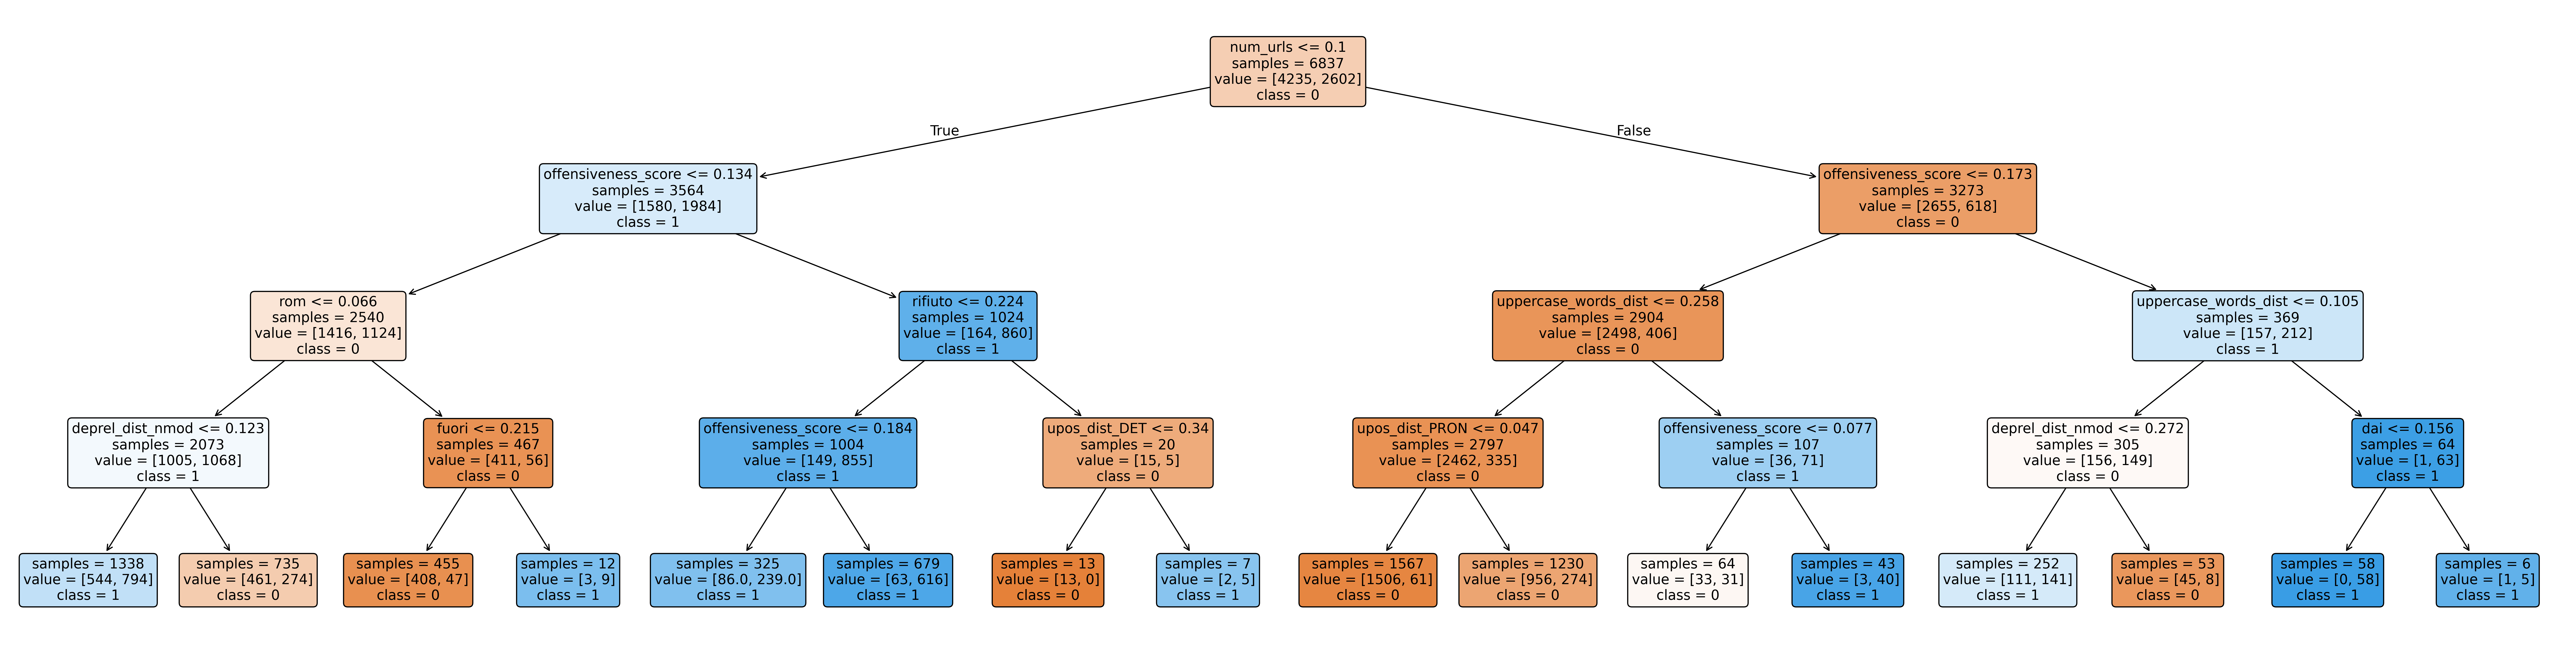

In [37]:
plt.figure(figsize=(40, 10), dpi=400)
plot_tree(best_exp,
          feature_names=train_X_no_embs.columns,
          class_names=['0', '1'], 
          filled=True, 
          rounded=True,
          fontsize=12,
          max_depth=None,
          impurity=False,
          proportion=False)
plt.show()